## The initial build up of LightGBM model
- easy to build. But turn out to have severe overfitting problem after fine-tuning.
- Maybe the logic of LightGBM does not suit a high precision required model?

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
data = pd.read_csv('../data/parsed_train.tsv', sep='\t')
data[:5]

,record_number,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,category_id,item_price,quantity,bt,package_size,weight,tz_dis,dis,cross_city,cross_state,acc_hour,pay_hour,acc_date,target
0,1,0,0.0,3,5,13,27.95,1,0,2,5.0,2.0,3.001315,1.0,1.0,15,3,20190326,3
1,3,0,4.5,3,5,1,19.90,1,0,0,9.0,-2.0,1.114014,1.0,1.0,16,0,20190107,3
2,6,0,0.0,3,5,3,10.39,1,0,0,1.0,-2.0,1.608366,1.0,1.0,19,14,20190419,3
3,7,0,0.0,3,5,11,5.70,1,0,0,0.0,1.0,2.784471,1.0,1.0,17,9,20190208,3
4,9,3,0.0,2,8,18,5.55,1,0,1,0.0,-1.0,1.568966,1.0,1.0,9,4,20191012,3


In [11]:
# define input and output feature
x = data.drop(['record_number', 'target'],axis=1)
y = data.target

# y.value_counts()

In [12]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [13]:
# create dataset for lightgbm
# Define categorical features
cat_feats = ['shipment_method_id','category_id', 'bt', 'package_size', 'cross_city', 'cross_state']
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_feats, params={"max_bin": 1000})
lgb_eval = lgb.Dataset(x_test, y_test, categorical_feature=cat_feats, reference=lgb_train, params = {"max_bin":1000})

In [14]:

def custom_asymmetric_eval2(preds, train_data):
    labels = train_data.get_label()
    preds = np.round(preds)
    residual = (labels - preds).astype("int")
    loss = np.where(residual < 0, residual * -0.6, residual * 0.4) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [15]:
# specify configurations as a dict
# loss function comes to 'objective'
# eval function comes to 'eval_metric'
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [16]:
print('Starting training...')
# train
results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=130,
                valid_sets=[lgb_eval],
                categorical_feature=cat_feats,
                feval=custom_asymmetric_eval2,
                early_stopping_rounds=3,
                evals_result = results)

print('Saving model...')
# save model to file
#gbm.save_model('../para/LightGBM.txt')

Starting training...
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.688613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/home/zhangr235_gmail_com/anaconda3/envs/py38/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/zhangr235_gmail_com/anaconda3/envs/py38/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's l1: 1.00998	valid_0's l2: 2.52166	valid_0's custom_asymmetric_eval: 0.491986


/home/zhangr235_gmail_com/anaconda3/envs/py38/lib/python3.8/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	valid_0's l1: 1.00244	valid_0's l2: 2.48559	valid_0's custom_asymmetric_eval: 0.491959
[3]	valid_0's l1: 0.996021	valid_0's l2: 2.45377	valid_0's custom_asymmetric_eval: 0.491077
[4]	valid_0's l1: 0.990882	valid_0's l2: 2.42417	valid_0's custom_asymmetric_eval: 0.486559
[5]	valid_0's l1: 0.987101	valid_0's l2: 2.39813	valid_0's custom_asymmetric_eval: 0.486414
[6]	valid_0's l1: 0.983606	valid_0's l2: 2.37382	valid_0's custom_asymmetric_eval: 0.483764
[7]	valid_0's l1: 0.98007	valid_0's l2: 2.35276	valid_0's custom_asymmetric_eval: 0.48385
[8]	valid_0's l1: 0.981414	valid_0's l2: 2.36187	valid_0's custom_asymmetric_eval: 0.483755
[9]	valid_0's l1: 0.97818	valid_0's l2: 2.34098	valid_0's custom_asymmetric_eval: 0.483816
[10]	valid_0's l1: 0.975423	valid_0's l2: 2.32271	valid_0's custom_asymmetric_eval: 0.483581
[11]	valid_0's l1: 0.972712	valid_0's l2: 2.30529	valid_0's custom_asymmetric_eval: 0.483843
[12]	valid_0's l1: 0.973635	valid_0's l2: 2.31186	valid_0's custom_asymmetric_eval

## Diagnosis

The min loss score is fancy, but only on valid set 

In [20]:
min(results['valid_0']['custom_asymmetric_eval'])

0.389584882089857

Plot the tree, feature importance, loss curve:

<AxesSubplot:>

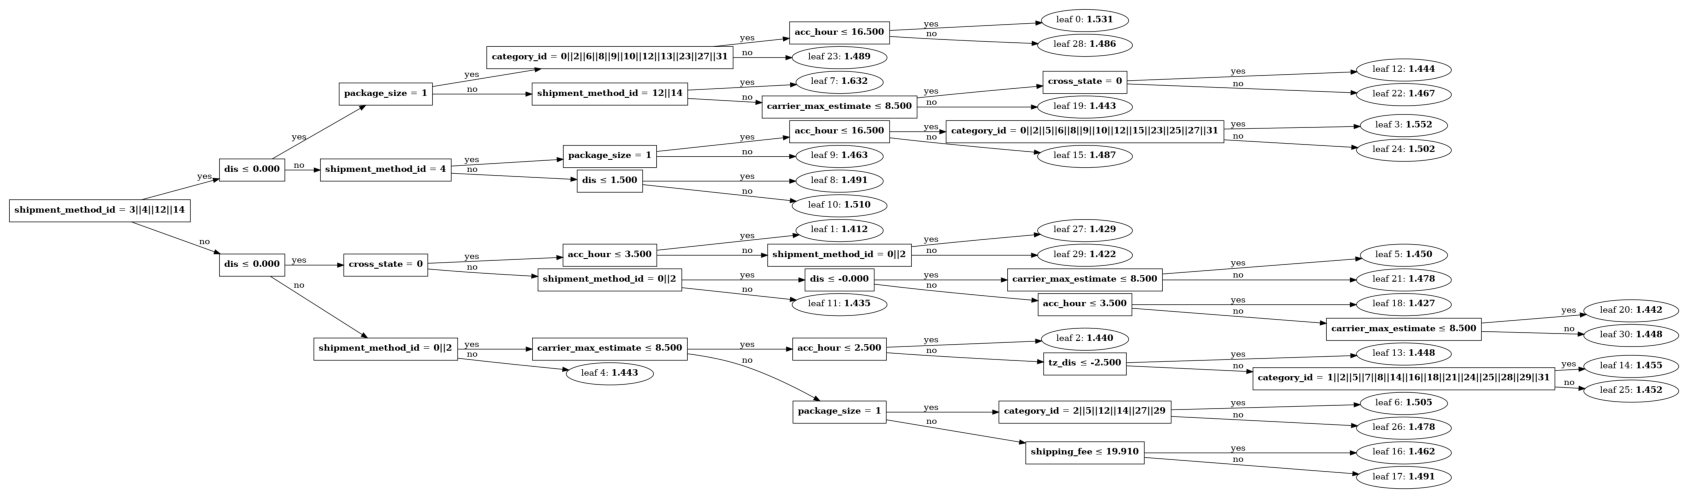

In [19]:
lgb.plot_tree(gbm,figsize=(30,40))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

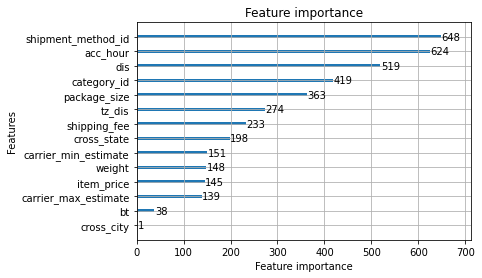

In [21]:
lgb.plot_importance(gbm)

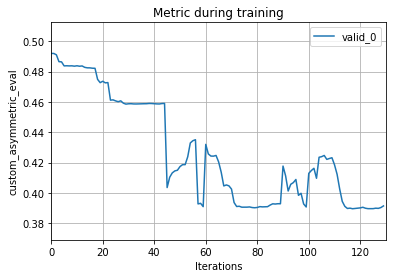

In [25]:
ax = lgb.plot_metric(results)

Prediction and save to file

In [28]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
metrics.classification_report(y_test,model.predict(x_test))

Starting predicting...


In [33]:
# load from file
bst = lgb.Booster(model_file='../para/LightGBM.txt')